# NER

In this excercise we will explore Named Entities Recognition task.

Imagine that you need to extract some specific information from your texts. First you might want to check how existing models manage to solve this task on your data. To this end you will analyze the performance of pretrained NER model on a dataset using the tools of [Transformers](https://huggingface.co/docs/transformers/index) library by huggingface that is one of the most common packages for working with NLP models.

You can follow this [tutorial](https://huggingface.co/learn/nlp-course/chapter7/2?fw=pt) to get ideas and extra information.

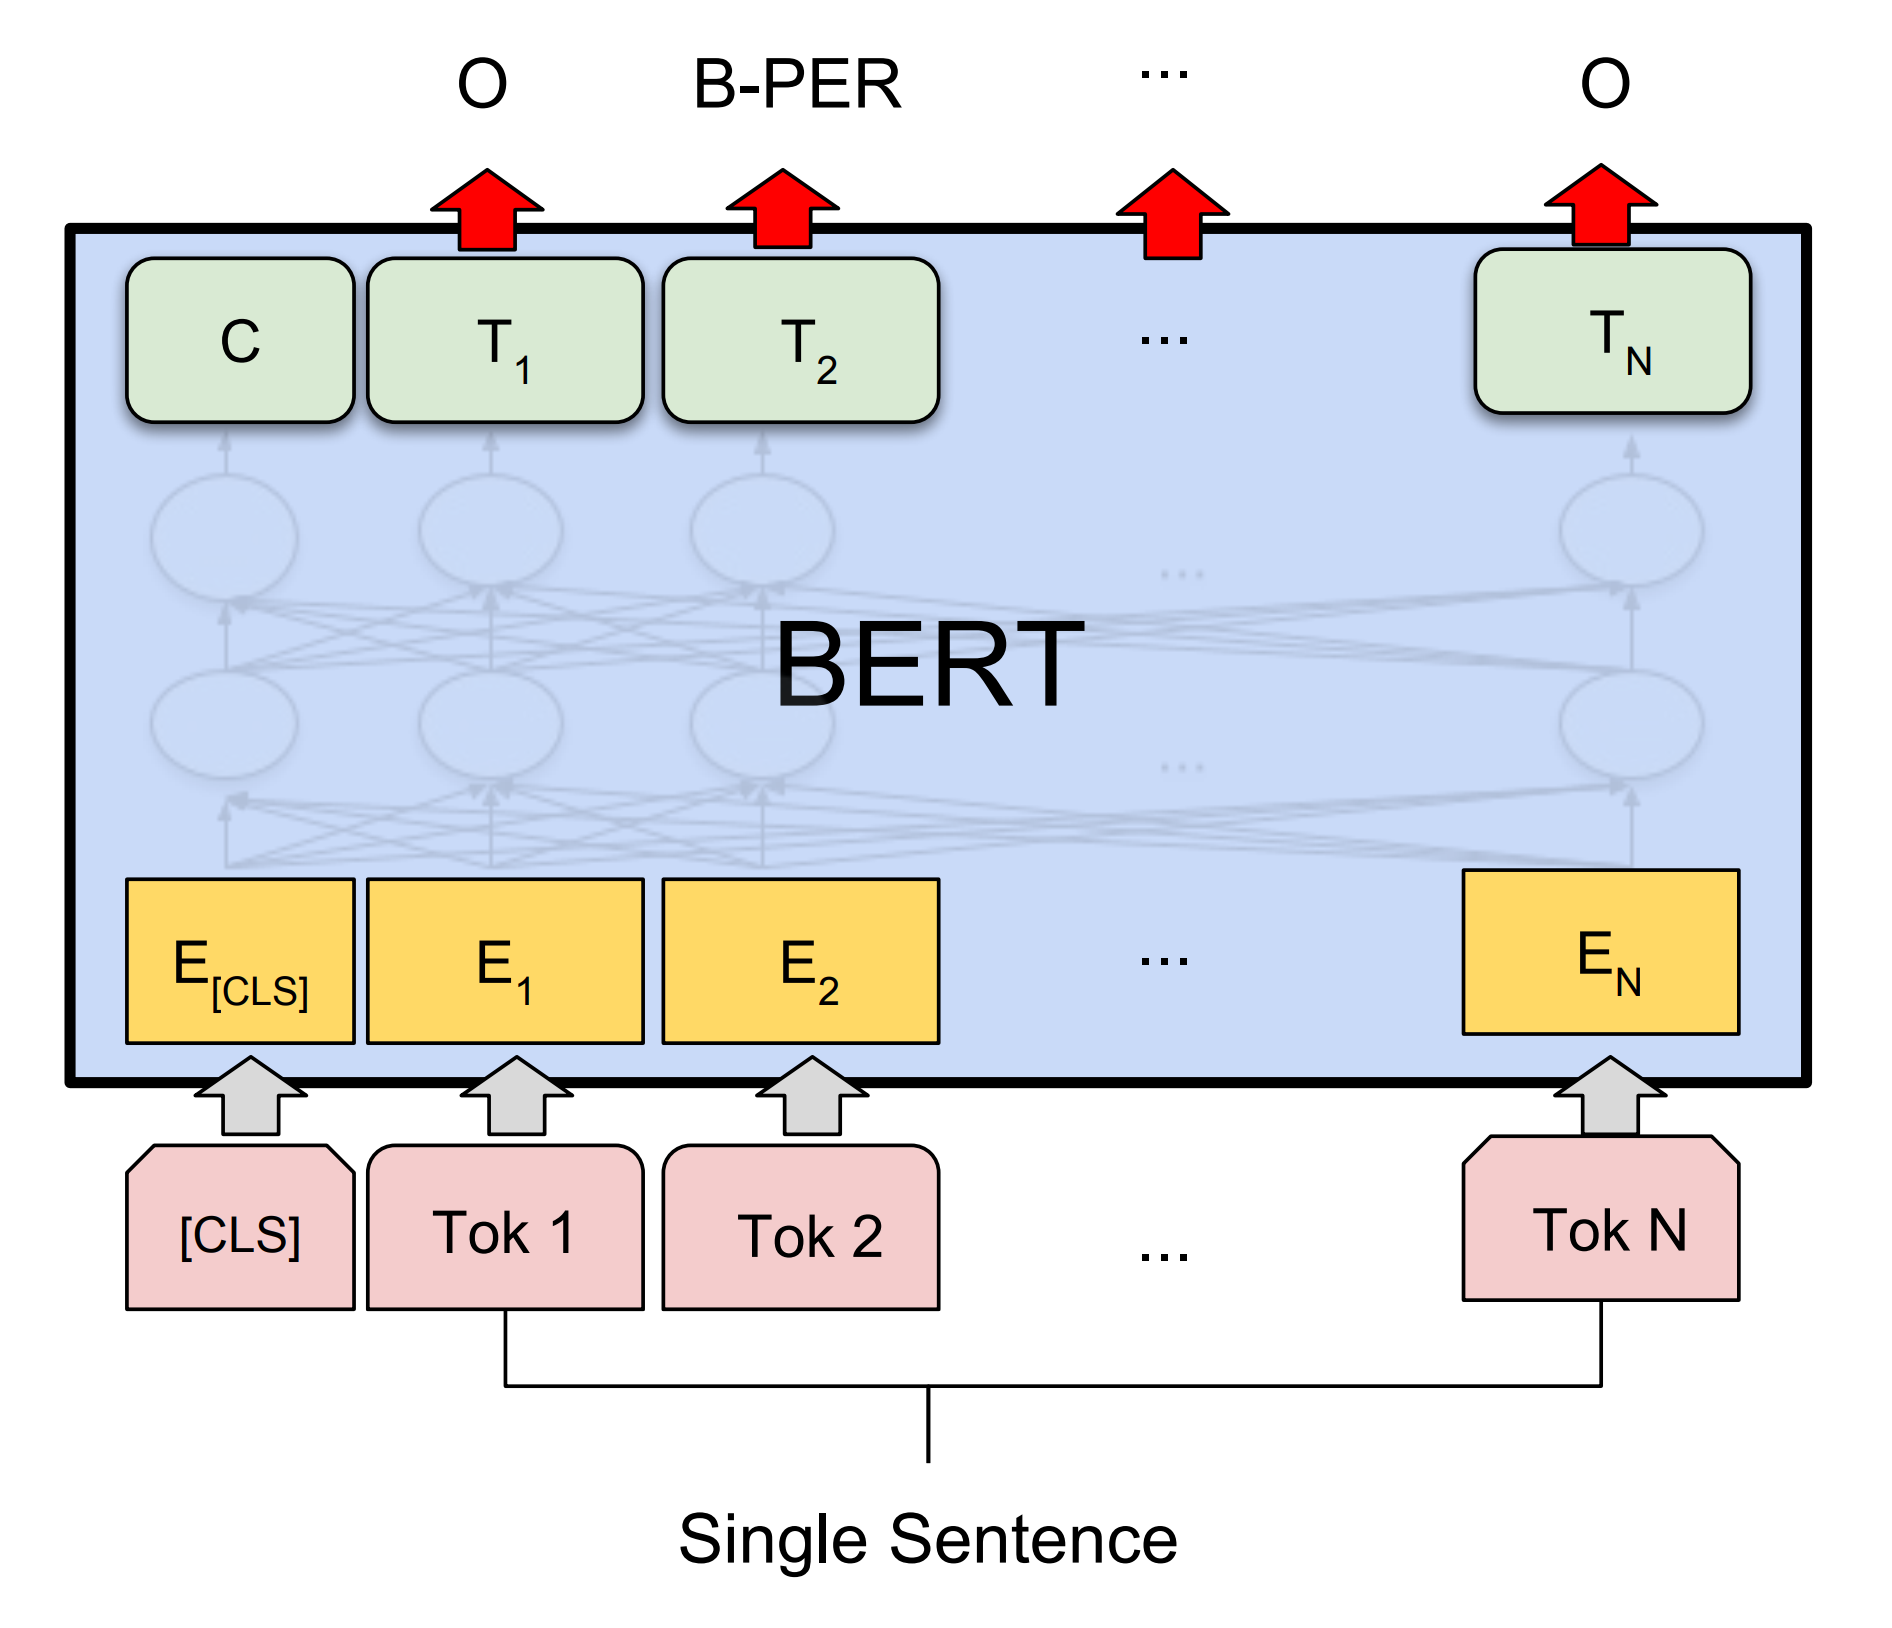

## Install and import libraries

In [ ]:
!pip install transformers datasets evaluate seqeval -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 48.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 87.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 42.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 23.7 MB/s eta 0:0

In [ ]:
import numpy as np
import torch


from datasets import load_dataset
import evaluate
from transformers import AutoTokenizer
from transformers import DataCollatorForTokenClassification
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
from transformers import pipeline

## Dataset



[Datasets](https://github.com/huggingface/datasets) library allows to load  popular datasets for various ML tasks. We'll use dataset Wikiann containing Wikipedia texts for different lanuages labeled with named entities.

In [ ]:
ds = load_dataset("wikiann", "en")

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Dataset wikiann downloaded and prepared to /root/.cache/huggingface/datasets/wikiann/en/1.1.0/4bfd4fe4468ab78bb6e096968f61fab7a888f44f9d3371c2f3fea7e74a5a354e. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Dataset is split into train, test and validation subsets. Data contains tokens, NER tags, language indicator and NER spans.

In [ ]:
ds

DatasetDict({
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'spans'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'spans'],
        num_rows: 10000
    })
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'spans'],
        num_rows: 20000
    })
})

To access single sample we should select subset and sample index.
Print some examples from the dataset.

In [ ]:
print('The first item form the validation set')
print(ds['validation'][0])
print('\nThe last item form the test set')
print(ds['test'][-1])
print('\nThe 10th item form the train set')
print(ds['train'][10])

The first item form the validation set
{'tokens': ['Sioux', 'Falls', 'Arena', '(', 'Sioux', 'Falls', ',', 'South', 'Dakota', ')'], 'ner_tags': [3, 4, 4, 0, 5, 6, 6, 6, 6, 0], 'langs': ['en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en'], 'spans': ['ORG: Sioux Falls Arena', 'LOC: Sioux Falls , South Dakota']}

The last item form the test set
{'tokens': ['|', 'align=left|', 'Free', 'Australia', 'Party'], 'ner_tags': [0, 0, 3, 4, 4], 'langs': ['en', 'en', 'en', 'en', 'en'], 'spans': ['ORG: Free Australia Party']}

The 10th item form the train set
{'tokens': ['102.7', 'MHz', 'Triple', 'J', '–', 'ABC'], 'ner_tags': [0, 0, 3, 4, 0, 3], 'langs': ['en', 'en', 'en', 'en', 'en', 'en'], 'spans': ['ORG: Triple J', 'ORG: ABC']}


Field *tokens* contains input sentences split into words. Field *ner_tags* contains ids of NER markup tags in BIO format, first token of each entitiy is marked with B-prefix, inside tokens are marked with I-prefix, tokens that do not belong to any of named entities are labeled with O tag.

Which entities are presented in the dataset?
Let's have a look at the names of all NER tags the dataset include.

In [ ]:
train_ents = ds['train'].features[f'ner_tags'].feature.names
val_ents = ds['validation'].features[f'ner_tags'].feature.names
test_ents = ds['test'].features[f'ner_tags'].feature.names

all_ents = list(set(train_ents + val_ents + test_ents))
all_ents

['O', 'B-PER', 'B-ORG', 'I-PER', 'B-LOC', 'I-ORG', 'I-LOC']

Create dictionaries to map tag ids (stored in the field ner_tags) to the names of the tags.

In [ ]:
ents_by_order = ds['train'].features[f'ner_tags'].feature.names
id_to_tag = {}
for i, tag in enumerate(ents_by_order):
  id_to_tag[i] = tag
id_to_tag

{0: 'O',
 1: 'B-PER',
 2: 'I-PER',
 3: 'B-ORG',
 4: 'I-ORG',
 5: 'B-LOC',
 6: 'I-LOC'}

How many examples does the dataset contain for each of the entity types?

In [ ]:
for phase in ['train', 'validation', 'test']:
    print(phase)
    print('-'*10)
    nt_list = ds[phase]['ner_tags']
    # Let's flatten the list of lists inside the 'ner_tags' key
    flat_list = [item for sublist in nt_list for item in sublist]
    # Counting number of occurrences of each tag using the above distionary
    for id, tag in id_to_tag.items():
        print(tag, '\t' ,flat_list.count(id))
    print()

train
----------
O 	 81362
B-PER 	 9164
I-PER 	 14698
B-ORG 	 9422
I-ORG 	 23226
B-LOC 	 9345
I-LOC 	 13177

validation
----------
O 	 40875
B-PER 	 4635
I-PER 	 7520
B-ORG 	 4677
I-ORG 	 11638
B-LOC 	 4834
I-LOC 	 6357

test
----------
O 	 40834
B-PER 	 4556
I-PER 	 7480
B-ORG 	 4745
I-ORG 	 11607
B-LOC 	 4657
I-LOC 	 6447



## Preprocessing

Transformer-based models use Byte-Pair Encoding (BPE) tokenization that splits texts into tokens (words or subwords) according to their occurence in training corpus. So to apply the model we need to preprocess input sentences using tokenizer built during the training of the model.

In this exercise we will use [NER BERT model](https://huggingface.co/dslim/bert-base-NER). on CoNLL-2003 dataset. The model was trained for NER task with entity types contained in our dataset so we can use it to predict names entities for texts in our dataset.

In [ ]:
model_name = 'dslim/bert-base-NER'

We will initialize tokenizer using AutoTokenizer.

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_name)

Print some examples of tokenized texts from the dataset.

In [ ]:
# ds_c = load_dataset("conll2003")

In [ ]:
def print_tokenizer_example(example_token):
    """
    Prints the text and the tokenized text.
    """
    txt = ' '.join(example_token['tokens'])
    tok = tokenizer(txt)
    token_ids = tok['input_ids']
    tokens = tokenizer.convert_ids_to_tokens(token_ids)
    print(txt)
    print(tokens)

In [ ]:
print('The first item of the train set:')
print_tokenizer_example(ds['train'][0])

print('\nThe 100th item of the vlidation set:')
print_tokenizer_example(ds['validation'][100])

print('\nThe last item of the test set:')
print_tokenizer_example(ds['test'][-1])


The first item of the train set:
R.H. Saunders ( St. Lawrence River ) ( 968 MW )
['[CLS]', 'R', '.', 'H', '.', 'Saunders', '(', 'St', '.', 'Lawrence', 'River', ')', '(', '96', '##8', 'MW', ')', '[SEP]']

The 100th item of the vlidation set:
Peculiar , Missouri
['[CLS]', 'P', '##ec', '##uli', '##ar', ',', 'Missouri', '[SEP]']

The last item of the test set:
| align=left| Free Australia Party
['[CLS]', '|', 'al', '##ign', '=', 'left', '|', 'Free', 'Australia', 'Party', '[SEP]']


Tokenizer output contains *input_ids* -- ids of tokens in model's vocabulary and *attention_mask* -- list of numbers 1 or 0 where 1 corresponds to tokens from input and 0 corresponds to padding special tokens [*PAD*].

As we can see new tokens do not match original tokenization of the dataset (in the dataset sentences were split into words) which means that we need to align NER labels from the dataset with BERT tokenized sentences.
There are different way for creating NER markup with subword tokenization, here we will the following strategy:
* Assign entitity tag only for the starting subtoken of the word
* Tag all inner subtokens with special label -100 because this index is ignored in loss function calculation.
* Mark special tokens ([CLS], [SEP], [PAD], [UNK]) with -100 label.


For example,

    Initial markup: Johnson(B-Person)

    Markup after tokenization: [CLS](-100) - John(B-Person) - ##son(-100)


Create a function that assigns entity label to the first subtoken within this entity and label -100 for all the rest subtokens of the entity and special tokens.

Tokenize dataset texts and create new labels using this function.

In [ ]:
def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            # a new word
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        else:
            new_labels.append(-100)

    return new_labels

Let's add the `-100` to the id_to_tag dictionary

In [ ]:
id_to_tag[-100] = '-100'

In [ ]:
def print_aligend_example(token_example):
    """
    Aligns and prints an example.
    """
    tokens = token_example["tokens"]
    labels = token_example["ner_tags"]
    inputs = tokenizer(token_example["tokens"], is_split_into_words=True)

    word_ids = inputs.word_ids()
    aligned_labels = (align_labels_with_tokens(labels, word_ids))
    sub_tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"])

    print('Original tokens:\t', tokens)
    print('Sub-tokens:\t\t', sub_tokens)
    print('Aligend labels:')
    for i, sb in enumerate(sub_tokens):
        tag = id_to_tag[aligned_labels[i]]
        print(f'{sb}({tag})  ', end = ' ')



In [ ]:
print_aligend_example(ds['train'][5])



Original tokens:	 ['St.', 'Mary', "'s", 'Catholic', 'Church', '(', 'Sandusky', ',', 'Ohio', ')']
Sub-tokens:		 ['[CLS]', 'St', '.', 'Mary', "'", 's', 'Catholic', 'Church', '(', 'Sand', '##usk', '##y', ',', 'Ohio', ')', '[SEP]']
Aligend labels:
[CLS](-100)   St(B-ORG)   .(-100)   Mary(I-ORG)   '(I-ORG)   s(-100)   Catholic(I-ORG)   Church(I-ORG)   ((I-ORG)   Sand(I-ORG)   ##usk(-100)   ##y(-100)   ,(I-ORG)   Ohio(I-ORG)   )(I-ORG)   [SEP](-100)   

Preprocess all dataset

In [ ]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"], truncation=True, is_split_into_words=True
    )
    all_labels = examples["ner_tags"]
    new_labels = []
    for i, labels in enumerate(all_labels):
        word_ids = tokenized_inputs.word_ids(i)
        new_labels.append(align_labels_with_tokens(labels, word_ids))

    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs

Running on the dataset

In [ ]:
tokenized_datasets = ds.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=ds["train"].column_names,
)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Let's print another example

In [ ]:
example = tokenized_datasets['train'][666]
tokens = tokenizer.convert_ids_to_tokens(example["input_ids"])
ners = example['labels']
for t, n in zip(tokens,ners):
    print(f'{t}({id_to_tag[n]})', end='\t')

[CLS](-100)	The(O)	song(O)	was(O)	recorded(O)	at(O)	G(B-ORG)	##rouse(-100)	Lodge(I-ORG)	,(O)	under(O)	the(O)	supervision(O)	of(O)	producer(O)	Jack(B-PER)	##nife(-100)	Lee(I-PER)	.(O)	[SEP](-100)	

## Model Predictions Analysis

# New Section

Now let's load pretrained model for token classification to see how it works on our dataset.

In [ ]:
from transformers import AutoModelForTokenClassification
model = AutoModelForTokenClassification.from_pretrained(model_name)

In [ ]:
model

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

In [ ]:
model.num_labels

9

In [ ]:
model.config

BertConfig {
  "_name_or_path": "dslim/bert-base-NER",
  "_num_labels": 9,
  "architectures": [
    "BertForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "O",
    "1": "B-MISC",
    "2": "I-MISC",
    "3": "B-PER",
    "4": "I-PER",
    "5": "B-ORG",
    "6": "I-ORG",
    "7": "B-LOC",
    "8": "I-LOC"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "B-LOC": 7,
    "B-MISC": 1,
    "B-ORG": 5,
    "B-PER": 3,
    "I-LOC": 8,
    "I-MISC": 2,
    "I-ORG": 6,
    "I-PER": 4,
    "O": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.29.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size"

Check model's performance on several examples from the dataset:
* Tokenize input text
* Run model using input_ids and attention_mask from tokenized input
* Get predicted NER labels for model's output using id2label from the config of the model.

Get the predictions for the sample of 100 examples from the test subset.

---



Defining a function to run the model and return the predicted NERs

In [ ]:
def predict_label(example, model):
    """
    Gets tokenized text and returns the model NER prediction
    """
    # Converting to tensors
    input_ids = torch.tensor(example["input_ids"]).unsqueeze(0)
    attention_mask = torch.tensor(example["attention_mask"]).unsqueeze(0)
    true_labels = torch.tensor(example["labels"]).unsqueeze(0)

    # Running the model using input_ids and ettention_mask
    outputs = model(input_ids, attention_mask=attention_mask)

    # Getting predicted NER labels for model's output
    predicted_ids = torch.argmax(outputs.logits, dim=2)
    predicted_labels = []
    for id in predicted_ids.tolist()[0]:
        predicted_labels.append(model.config.id2label[id])
    return predicted_labels, predicted_ids, true_labels

Sampling 100 examples from the test set

In [ ]:
import random
sample_indexes = random.sample(range(len(tokenized_datasets['test'])), 100)

Running the model on the 100 examples

In [ ]:
for idx in sample_indexes:
    example = tokenized_datasets['test'][idx]
    # print(example)
    tokens = tokenizer.convert_ids_to_tokens(example["input_ids"])
    print(tokens)
    print(predict_label(example, model)[0])
    print()

['[CLS]', 'Anton', '##ia', '(', 'plant', ')', '[SEP]']
['O', 'B-ORG', 'O', 'O', 'O', 'O', 'O']

['[CLS]', 'CSI', ':', 'Miami', "'", "'", '[SEP]']
['O', 'B-ORG', 'O', 'B-LOC', 'O', 'O', 'O']

['[CLS]', "'", "'", 'T', '##hr', '##ow', '##back', ',', 'Vol', '.', '1', "'", "'", '-', 'Boy', '##z', 'II', 'Men', '[SEP]']
['O', 'O', 'O', 'O', 'O', 'O', 'I-MISC', 'O', 'O', 'O', 'I-MISC', 'O', 'O', 'O', 'B-MISC', 'I-MISC', 'I-MISC', 'I-MISC', 'O']

['[CLS]', "'", "'", 'Mega', '##loc', '##ran', '##chia', 'fish', '##eri', "'", "'", '[SEP]']
['O', 'O', 'O', 'B-MISC', 'O', 'I-MISC', 'O', 'O', 'O', 'O', 'O', 'O']

['[CLS]', '2012', '–', '13', 'FK', 'Austria', 'Wien', 'season', '[SEP]']
['O', 'O', 'O', 'O', 'B-ORG', 'I-ORG', 'I-ORG', 'O', 'O']

['[CLS]', 'After', 'graduating', ',', 'he', 'became', 'a', 'member', 'of', 'the', 'Ki', '##rov', 'Opera', 'in', 'Saint', 'Petersburg', 'in', '1981', '.', '[SEP]']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'I-ORG', 'I-ORG', 'O', 'B-LOC', 'I-LOC'

Let's take a look at incorrect predictions.

Analyze the model's output, which entities were predicted incorrectly, can you see some patterns?
Note that the dataset is labeled for three types of entites (PER, LOC, ORG) while the model also predicts extra type (MISC).

Test the model on your own examples and describe the result.

We can see that there are different labels

In [ ]:
print('Model tags:\n', model.config.id2label)
print('Dataset tags:\n', id_to_tag)


Model tags:
 {0: 'O', 1: 'B-MISC', 2: 'I-MISC', 3: 'B-PER', 4: 'I-PER', 5: 'B-ORG', 6: 'I-ORG', 7: 'B-LOC', 8: 'I-LOC'}
Dataset tags:
 {0: 'O', 1: 'B-PER', 2: 'I-PER', 3: 'B-ORG', 4: 'I-ORG', 5: 'B-LOC', 6: 'I-LOC', -100: '-100'}


Let's define a function to calculates accuracy of one sample

We need to handle he -100 and MISC tags

In [ ]:
def get_accuracy(prediction, true_label):
    """
    Ignores the -100 and the MISC label
    """
    errors = 0
    true_label = true_label.tolist()[0]
    for p, t in zip(prediction, true_label):
        t = id_to_tag[t]
        if (t != '-100') and ('MISC' not in p) and (t != p):
            errors += 1
    acc = 1 - (errors/len(true_label))
    return acc

Let's calculate the accuracy for the 100 samples

In [ ]:
all_acc = []
all_preds_ids = []
all_true_labels = []

for idx in sample_indexes:
    example = tokenized_datasets['test'][idx]
    preds, pred_ids, true_label = predict_label(example, model)
    # Collecting outputs
    all_preds_ids += pred_ids.tolist()[0]
    all_true_labels += true_label.tolist()[0]
    # Calculating accuracy
    acc = get_accuracy(preds, true_label)
    all_acc.append(acc)
print('Mean accuracy:', np.mean(all_acc))

Mean accuracy: 0.825136270849893


Let's build a dictionary to convert between the model keys to the dataset keys (for example, the **B-PER** label is represented by 1 in the dataset, and by 3 in the model)

In [ ]:
model_to_dataset = {
    0: 0,
    1: 0,
    2: 0,
    3: 1,
    4: 2,
    5: 3,
    6: 4,
    7: 5,
    8: 6
}

In [ ]:
def process_output(predict_ids, true_labels):
    predict_ids_new = []
    true_labels_new = []
    i = 0
    for p, t in zip(predict_ids, true_labels):
        if t != -100:  # Ignore the -100 label
            true_labels_new.append(t)
            predict_ids_new.append(model_to_dataset[p])
    return predict_ids_new, true_labels_new

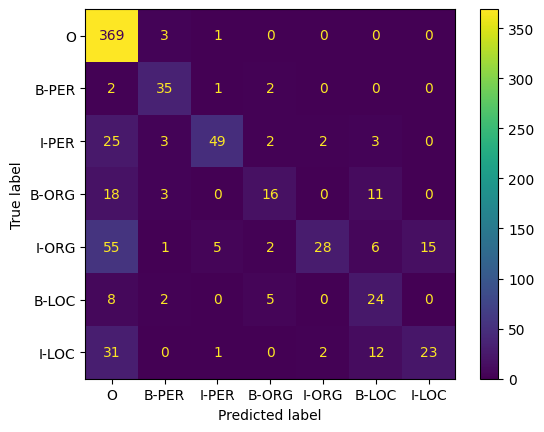

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predict_ids_new, true_labels_new = process_output(all_preds_ids, all_true_labels)

classes = list(id_to_tag.values())[:-1]
cm = confusion_matrix(true_labels_new, predict_ids_new)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot();

We can see that the most common label is O, as expected. We can see that the B-ORG label is miss-labeld as O in about half of the cases, but the I-ORG and I-LOC are miss-labeled as O in most of the cases. The B-PER and B-LOC are labeled correctly in most of the cases.

## Evaluation

The model was trained on CONLL-2003 dataset. We will evaluate model's performance on the test subset of this dataset.

Write code to evaluate the model:

* Load CONLL-2003 dataset
* Tokenize input texts and align NER tags markup
* Run the model to get predictions for test set
* Compute metrics using [seqeval](https://huggingface.co/spaces/evaluate-metric/seqeval) module of evaluate library (for evaluation we should ignore all non-starting subtokens within a word and special tokens).


### Loading the CONLL-2003 dataset

In [ ]:
con_ds = load_dataset("conll2003")
con_ds

Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

Dataset conll2003 downloaded and prepared to /root/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})

###Tokenizing and Aligning the Tags

We will used the `tokenize_and_align_labels` function

In [ ]:
con_tokenized_datasets = con_ds.map(
    tokenize_and_align_labels,
    batched=True
)

Map:   0%|          | 0/14041 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

### Running the model to predict the test set

We will define a function to ignore the -100 label which was created in the alignemnt but doesn't appear in the model.

In [ ]:
def remove_100_label(preds, labels):
    """
    Remove the -100 label and the corresponding prediction
    """
    new_preds = []
    new_labels = []
    for p, l in zip(preds, labels):
        # print('\np', p, '\tl', l)
        if (l != '-100') and (not ('MISC' in p)):
            new_preds.append(p)
            new_labels.append(l)
    return new_preds, new_labels

Let's run the model on the test set

In [ ]:
# Takes about 12 minuts
all_acc = []
all_preds = []
all_true_labels = []

# for example in tokenized_datasets['test'][:100]:
for example in tokenized_datasets['test']:
    preds, pred_ids, true_label = predict_label(example, model)
    # From Tensor to list
    true_label = true_label.tolist()[0]

    # From ID to NER name
    true_label_names = [id_to_tag[l] for l in true_label]

    preds, true_label_names = remove_100_label(preds, true_label_names)

    # Collecting outputs
    all_preds.append(preds)
    all_true_labels.append(true_label_names)

In [ ]:
print(all_preds)
print(all_true_labels)

[['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'B-LOC', 'O', 'O', 'O'], ['O', 'B-PER', 'I-PER', 'O', 'B-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'O'], ['B-LOC', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'B-PER', 'O', 'O', 'O'], ['B-PER', 'I-PER', 'I-PER', 'O', 'B-PER', 'I-PER', 'O'], ['O', 'O', 'B-PER'], ['O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'I-LOC'], ['B-PER', 'I-PER', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'I-LOC', 'O'], ['O', 'O', 'I-ORG', 'O'], ['B-LOC', 'I-LOC', 'I-LOC', 'O', 'B-LOC', 'O', 'B-LOC'], ['B-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'B-PER', 'O', 'O', 'B-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O'], ['B-ORG', 'I-ORG', 'I-ORG', 'I-ORG'], ['B-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'I-ORG'], ['B-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['B-LOC', 'O', 'I-LOC'], ['B-PER', 'I-PER

### Computing the matrix

In [ ]:
seqeval = evaluate.load("seqeval")
results = seqeval.compute(predictions=all_preds, references=all_true_labels)


In [ ]:
results

{'LOC': {'precision': 0.3692873122403324,
  'recall': 0.5022821125842208,
  'f1': 0.4256377198637075,
  'number': 4601},
 'ORG': {'precision': 0.5403081332855607,
  'recall': 0.3506161357823762,
  'f1': 0.42526790750141,
  'number': 4301},
 'PER': {'precision': 0.6390543223244901,
  'recall': 0.7834070796460177,
  'f1': 0.7039061723486731,
  'number': 4520},
 'overall_precision': 0.5044551062371487,
 'overall_recall': 0.5483534495604232,
 'overall_f1': 0.5254890761102384,
 'overall_accuracy': 0.7787999843849627}

We can see that the overall accuracy is 0.78, but since the label accuracies are much lower, the high accuracy is possibly because of the large number of 'O's in the data. We can see that the best perfomance are for the PER label, and that the ORG label is harder to identify (recall of 0.35) and that the LOC label is usually miss-labeled (precision of 0.37).

## Bonus: Fine-tuning
If you want to dive deeper in NER task, try to fine-tune base BERT model on Wikiann dataset following the tutorial.